In [1]:
from torchvision.models import resnet18
from pprint import pprint
import torch.nn as nn

/home/itrushkin/.virtualenvs/git-re-basin/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import NamedTuple
from collections import defaultdict
from numpy import random

class PermutationSpec(NamedTuple):
    perm_to_axes: dict
    axes_to_perm: dict

rngmix = lambda rng, x: random.default_rng([rng._bit_generator._seed_seq.entropy, hash(x)])

def permutation_spec_from_axes_to_perm(axes_to_perm: dict):
    perm_to_axes = defaultdict(list)
    for wk, axis_perms in axes_to_perm.items():
        for axis, perm in enumerate(axis_perms):
            if perm is not None:
                perm_to_axes[perm].append((wk, axis))
    return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)

def resnet18_permutation_spec():
    conv = lambda name, p_in, p_out: {f"{name}.weight": (p_out, p_in, None, None)}
#     norm = lambda name, p: {f"{name}.weight": (p, ), f"{name}.bias": (p, )}
    dense = lambda name, p_in, p_out: {f"{name}.weight": (p_out, p_in), f"{name}.bias": (p_out, )}

    # This is for easy blocks that use a residual connection, without any change in the number of channels.
    easyblock = lambda name, p: {
        **conv(f"{name}.conv1", p, f"P_{name}_inner"),
#         **norm(f"{name}.bn1", f"P_{name}_inner"),
        **conv(f"{name}.conv2", f"P_{name}_inner", p),
#         **norm(f"{name}.bn2", p)
    }

    # This is for blocks that use a residual connection, but change the number of channels via a Conv.
    shortcutblock = lambda name, p_in, p_out: {
        **conv(f"{name}.conv1", p_in, f"P_{name}_inner"),
#         **norm(f"{name}.bn1", f"P_{name}_inner"),
        **conv(f"{name}.conv2", f"P_{name}_inner", p_out),
#         **norm(f"{name}.bn2", p_out),
        **conv(f"{name}.downsample.0", p_in, p_out),
#         **norm(f"{name}.downsample.1", p_out),
    }

    ps = permutation_spec_from_axes_to_perm({
        **conv("conv1", None, "P_bg0"),
#         **norm("bn1", "P_bg0"),
        #
        **easyblock("layer1.0", "P_bg0"),
        **easyblock("layer1.1", "P_bg0"),
        #
        **shortcutblock("layer2.0", "P_bg0", "P_bg1"),
        **easyblock("layer2.1", "P_bg1"),
        
        **shortcutblock("layer3.0", "P_bg1", "P_bg2"),
        **easyblock("layer3.1", "P_bg2"),
        
        **shortcutblock("layer4.0", "P_bg2", "P_bg3"),
        **easyblock("layer4.1", "P_bg3"),
        #
        **dense("fc", "P_bg3", None),
    })

    return ps

In [18]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def get_permuted_param(ps, perm, k: str, params, except_axis=None):
    """Get parameter `k` from `params`, with the permutations applied."""
    w = params[k]
    axes_to_perm = ps.axes_to_perm.get(k)
    if axes_to_perm is None:
        return w
    for axis, p in enumerate(axes_to_perm):
        # Skip the axis we're trying to permute.
        if axis == except_axis:
            continue

        # None indicates that there is no permutation relevant to that axis.
        if p is not None:
            w = np.take(w, perm[p], axis=axis)

    return w

def apply_permutation(ps, perm, params):
    """Apply a `perm` to `params`."""
    return {k: get_permuted_param(ps, perm, k, params) for k in params.keys()}

def weight_matching(rng,
                    ps,
                    params_a,
                    params_b,
                    max_iter=100,
                    init_perm=None,
                    silent=False):
    """Find a permutation of `params_b` to make them match `params_a`."""
    perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}

    perm = {p: np.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
    perm_names = list(perm.keys())

    for iteration in range(max_iter):
        progress = False
        for p_ix in rngmix(rng, iteration).permutation(len(perm_names)):
            p = perm_names[p_ix]
            n = perm_sizes[p]
            A = np.zeros((n, n))
            for wk, axis in ps.perm_to_axes[p]:
                w_a = params_a[wk]
                if 'bn' in wk or 'downsample.1' in wk: # normalization layer
                    w_b = w_a.copy()
                else:
                    w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)
                w_a = np.moveaxis(w_a, axis, 0).reshape((n, -1))
                w_b = np.moveaxis(w_b, axis, 0).reshape((n, -1))
                A += w_a @ w_b.T

            ri, ci = linear_sum_assignment(A, maximize=True)
            assert (ri == np.arange(len(ri))).all()

            oldL = np.vdot(A, np.eye(n)[perm[p]])
            newL = np.vdot(A, np.eye(n)[ci, :])
            if not silent: print(f"{iteration}/{p}: {newL - oldL}")
            progress = progress or newL > oldL + 1e-12

            perm[p] = np.array(ci)

        if not progress:
            break

    return perm

In [19]:
import pickle

def load_model(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
model_a = load_model('model_0.pkl')
model_b = load_model('model_1.pkl')

In [20]:
rng = np.random.default_rng(123)
permutation_spec = resnet18_permutation_spec()
permutation = weight_matching(rng, permutation_spec, model_a, model_b)
model_b_permuted = apply_permutation(permutation_spec, permutation, model_b)
for k in model_b:
    if 'bn' in k or 'downsample.1' in k:
        model_b_permuted[k] = model_a[k]

0/P_layer1.1_inner: 19.326712337322533
0/P_layer3.1_inner: 41.257362816133536
0/P_bg0: 18.05645225252556
0/P_bg3: 120.4246008632964
0/P_bg2: 7.448564442107454
0/P_bg1: 32.41513375820432
0/P_layer4.1_inner: 30.666908277431503
0/P_layer1.0_inner: 9.214273978024721
0/P_layer2.1_inner: 15.802347697783262
0/P_layer3.0_inner: 29.260348424082622
0/P_layer2.0_inner: 16.671165141742676
0/P_layer4.0_inner: 36.91022380301729
1/P_layer4.1_inner: 0.0
1/P_bg1: 0.0
1/P_bg3: 0.5653393063003023
1/P_layer3.1_inner: 8.448018233757466
1/P_layer1.0_inner: 0.0
1/P_bg0: 0.300375577819068
1/P_layer3.0_inner: 0.0
1/P_layer4.0_inner: 1.4227170487865806
1/P_layer1.1_inner: 7.771536125335842
1/P_layer2.1_inner: 0.0
1/P_layer2.0_inner: 0.8276386857032776
1/P_bg2: 0.0
2/P_layer1.0_inner: 1.3170132578816265
2/P_bg2: 0.0
2/P_layer4.0_inner: 0.0
2/P_layer3.1_inner: 0.0
2/P_layer3.0_inner: 0.0
2/P_layer4.1_inner: 2.0831035614246503
2/P_bg0: 0.0
2/P_layer2.1_inner: 0.0
2/P_bg3: 0.20646792269326397
2/P_layer2.0_inner: 0.

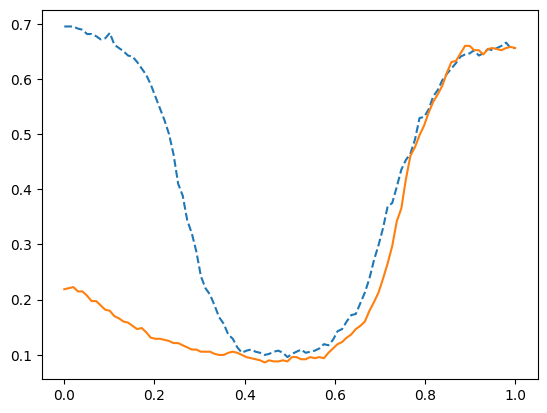

In [21]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch

valid_dataset = CIFAR10('.', train=False, transform=ToTensor())
valid_loader = DataLoader(valid_dataset, batch_size=512)

class Conv2dLayerNorm(nn.LayerNorm):        
    def forward(self, x):
        transposed = x.transpose(1,3)
        result = super().forward(transposed)
        
        return result.transpose(3,1)

def gn(channels):
    return nn.GroupNorm(32, channels)

def merge_models(m1, m2, _lambda):
    m3 = dict()
    for n in m1:
        m3[n] = m1[n] * _lambda + m2[n] * (1 - _lambda)
    m3_torch = resnet18(num_classes=10, norm_layer=gn)
    m3_torch.load_state_dict({k: torch.tensor(v) for k, v in m3.items()})
    return m3_torch

def evaluate_model(model):
    model.eval()
    total_samples = 0
    val_score = 0
    for data, target in valid_loader:
        outputs = model(data)
        pred = outputs.argmax(dim=1)
        val_score += pred.eq(target).sum().cpu().numpy()
        total_samples += len(target)
        acc = val_score / total_samples
        return acc

lambdas, accs, accs_permuted = [], [], []
for _lambda in np.linspace(0, 1, 100):
    model_c = merge_models(model_a, model_b, _lambda)
    model_c_permuted = merge_models(model_a, model_b_permuted, _lambda)
    acc = evaluate_model(model_c)
    acc_permuted = evaluate_model(model_c_permuted)
    accs.append(acc)
    accs_permuted.append(acc_permuted)
    lambdas.append(_lambda)

plt.plot(lambdas, accs, '--')
plt.plot(lambdas, accs_permuted)

In [22]:
distance = 0
for n in model_b:
    d_permuted = np.linalg.norm(model_a[n] - model_b_permuted[n])
    d = np.linalg.norm(model_a[n] - model_b[n])
    if d_permuted > d:
        print(f'{n:30}: {d_permuted:.4f} > {d:.4f}')

In [24]:
model_c_torch = resnet18(num_classes=10, norm_layer=gn)
model_c_torch.load_state_dict({k: torch.tensor(model_b[k]) for k in model_b})
evaluate_model(model_c_torch)

0.6953125